<a href="https://colab.research.google.com/github/sdrangan/introml/blob/master/unit09_neural/demo2_mnist_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification via a Neural Network

In the the [MNIST SVM example](../svm/mnist_svm.ipynb), we introduced the classic MNIST digit classification problem and trained a simple SVM classifier for the model.  In this demo, we will try a simple neural network.  The network we will create will not perform quite as well -- we will obtain an accuracy of only around 97%, while the SVM classifier obtains an accuracy of over 98%.  However, once we understand these simple neural networks, we will be able to build more sophisticated networks that can obtain much better classification rate.  Also, in doing this demo, you will learn several important features of the `pytorch` package in addition to the concepts shown in the [simple neural network example](./demo1_synthetic.ipynb):

* How to construct multi-class classifiers using categorical cross entropy.
* How to save and load the model after training.  

## Loading PyTorch

We first load the `pytorch` packages as in the [simple neural network example](./demo1_synthetic.ipynb).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

We also load some other common packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Next, we download the data.  The first time you run this code, it will load the data into directory `../data`.  The downloader has a transform that sets the mean to `0.1307` and `0.3081`, which are the mean and std deviation in the MNIST data set in the way it is stored in the raw data.

In [19]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

# Download and load the training data
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)

# Download and load the test data
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)


We will also use the `plt_digit` function from the [MNIST SVM example](../svm/mnist_svm.ipynb) to display digits.

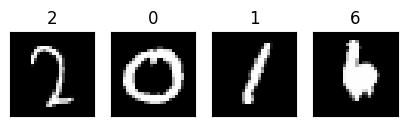

In [22]:
def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

# Select random digits
nplt = 4
nsamp = len(train_data)
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt, figsize=(5,10))
for i in range(nplt):
    ind = Iperm[i]

    # Get the data from the training data set
    x, y = train_data[ind]
    x = x.numpy()

    # Plot the image
    plt_digit(ax[i], x)
    ax[i].set_title(y)

## Creating a Simple Neural Network.

Now we create a very simple network.  The features are:
*  We have one hidden layer with `nh=100` units.  
*  One output layer with `nout=10` units, one for each of the 10 possible classes
*  The output activation is `softmax`, which is used for multi-class targets

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, nin, nh, nout):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nin, nh)
        self.fc2 = nn.Linear(nh, nout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)s
        x = F.softmax(x, dim=1)
        return x # Apply softmax to the output

nin = 28*28
nh = 100
nout = 10
model = Net(nin, nh, nout)


We print the model summary.

In [24]:
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


Epoch 1/30, Train Accuracy: 79.72%, Test Accuracy: 92.08%
Epoch 2/30, Train Accuracy: 93.06%, Test Accuracy: 93.70%
Epoch 3/30, Train Accuracy: 94.68%, Test Accuracy: 94.74%
Epoch 4/30, Train Accuracy: 95.55%, Test Accuracy: 95.13%
Epoch 5/30, Train Accuracy: 96.15%, Test Accuracy: 95.76%
Epoch 6/30, Train Accuracy: 96.63%, Test Accuracy: 95.93%
Epoch 7/30, Train Accuracy: 97.06%, Test Accuracy: 96.30%
Epoch 8/30, Train Accuracy: 97.36%, Test Accuracy: 96.46%
Epoch 9/30, Train Accuracy: 97.60%, Test Accuracy: 96.64%
Epoch 10/30, Train Accuracy: 97.84%, Test Accuracy: 96.63%
Epoch 11/30, Train Accuracy: 97.99%, Test Accuracy: 96.88%
Epoch 12/30, Train Accuracy: 98.19%, Test Accuracy: 96.82%
Epoch 13/30, Train Accuracy: 98.37%, Test Accuracy: 96.80%
Epoch 14/30, Train Accuracy: 98.48%, Test Accuracy: 96.98%
Epoch 15/30, Train Accuracy: 98.58%, Test Accuracy: 96.96%
Epoch 16/30, Train Accuracy: 98.69%, Test Accuracy: 96.98%
Epoch 17/30, Train Accuracy: 98.76%, Test Accuracy: 97.03%
Epoch 

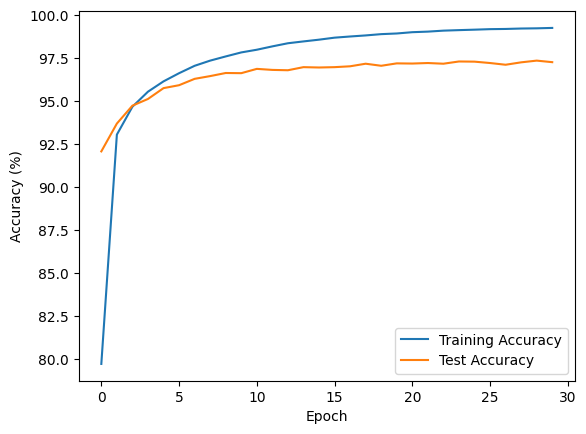

In [25]:
# prompt: Write code to train the network with an ADAM optimizer with 30 epochs and batch sizes of 100.  Record the test and training accuracy each epoch.

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training settings
batch_size = 100
epochs = 30

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []


# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)

    # Testing
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print("Finished Training")

#Plot the accuracy
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Training the Network

As before, to train the network, we have to select an optimizer and a loss function.  Since this is a multi-class classification problem, we select the `sparse_categorial_crossentropy` loss.  We use the `adam` optimizer as before.  You may want to play with the learning rate `lr`.   We also set the `metrics` that we wish to track during the optimization.  In this case, we select `accuracy` on the training set.

In [ ]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Keras provides a simple method `fit` to run the optimization.  You simply specify the number of epochs and the batch size, both discussed in class.  In addition, we specify the `validation_data` so that it can print the accuracy on the test data set as it performs the optimization.

In [ ]:
hist = model.fit(Xtr, ytr, epochs=30, batch_size=100, validation_data=(Xts,yts))

Epoch 1/30
600/600 [==============================] - 1s 2ms/step - loss: 0.0187 - accuracy: 0.9960 - val_loss: 0.0880 - val_accuracy: 0.9750
Epoch 2/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0165 - accuracy: 0.9966 - val_loss: 0.0890 - val_accuracy: 0.9747
Epoch 3/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 0.9968 - val_loss: 0.0904 - val_accuracy: 0.9738
Epoch 4/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0147 - accuracy: 0.9970 - val_loss: 0.0920 - val_accuracy: 0.9750
Epoch 5/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0927 - val_accuracy: 0.9741
Epoch 6/30
600/600 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.0844 - val_accuracy: 0.9770
Epoch 7/30
600/600 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 0.0891 - val_accuracy: 0.9753
Epoch 

After running the 10 epochs, you should obtain a test accuracy of around 96.5%.  If we run it for another a few epochs, we can get slightly higher results.  We can just run the `model.fit` command again, and it will start where it left off. You should get a little more than 97% accuracy.

Plot the training accuracy and validation accuracy as a function of epoches.
We see that the training accuracy keeps growing to 1, while the validation accuracy saturates to a value around 0.97

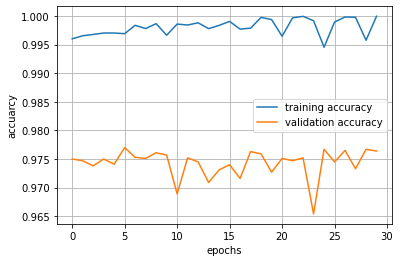

In [ ]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
score, acc = model.evaluate(Xts, yts, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.0965 - accuracy: 0.9764


## Saving and Loading the model

Since the training takes a long time, it is useful to save the results.  See the [keras page](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) for many more useful saving and loading features.

In [ ]:
model.save("mnist_mod.h5")

We can now reload the model with the `load_model` command.

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model("mnist_mod.h5")
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


We can test the performance on the test data set.  We can do this in two steps:

* We first compute the output logits, `z`, on the test data, `Xts`.  This will produce a matrix with 10 columns with one logits for each class.  
* Then we compute the predicted class labels `yhat` by finding the index of the column with the maximum value.

In [ ]:
z = model1.predict(Xts)
yhat = np.argmax(z,axis=1)

To see what happened, the code below prints the first 5 rows of the logits and the corresponding class estimate.

In [ ]:
mat = np.column_stack((z,yhat))
with np.printoptions(precision=3, suppress=True):
    for i in range(5):
        print('z[%d,:]='%i, z[i,:], ', yhat[%d]= '%i, yhat[i])

z[0,:]= [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] , yhat[0]=  7
z[1,:]= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] , yhat[1]=  2
z[2,:]= [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] , yhat[2]=  1
z[3,:]= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] , yhat[3]=  0
z[4,:]= [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] , yhat[4]=  4


In [ ]:
acc = np.mean(yhat == yts)
print("accuracy = %f" % acc)

accuracy = 0.976400


You can also use the built-in metric function, `sparse_categorical_accuracy`.  The function returns one output for each sample, so you need to take the mean of the results.

In [ ]:
from tensorflow.keras.metrics import sparse_categorical_accuracy
acc = np.mean(sparse_categorical_accuracy(yts, yhat1))
print("accuracy = %f" % acc)

accuracy = 0.976400
